# Read the prediction

In [1]:
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt

path = '/home/jovyan/work/gns-fragment/rollouts/Fragment/generalisation-test/002_A_E_3-C80-120-7-250.pkl'

with open(path, "rb") as file:
    rollout_data = pickle.load(file)

init_pos = rollout_data['initial_positions']
pred_pos = rollout_data['predicted_rollout']
gt_pos = rollout_data['ground_truth_rollout']
gt_pos = np.concatenate((init_pos, gt_pos), axis=0)
pred_pos = np.concatenate((init_pos, pred_pos), axis=0)
particle_type = rollout_data['particle_types']
init_strain = rollout_data['initial_strains']
pred_strain = rollout_data['predicted_strain']
gt_strain = rollout_data['ground_truth_strain']

#id = int(path.split('.p')[0].split('_')[-1])
# id = int(path.split('/')[-1].split('_')[0])   # generalisation 
# filename = rollout_data["metadata"]["file_test"][id].split('.n')[0]
# test_id, slab_thickness, charge_weight, standoff_d = filename.split('_')
# standoff_d, concrete_strength = standoff_d.split('C')
# Z = float(standoff_d) / (float(charge_weight) ** (1/3))   # sacled distance, 0.17-0.32
# Z = round(Z, 2)

# case = f"{filename}_Z={Z}"
# print(f'''Test id: {test_id}, 
#           Concrete strength: {concrete_strength} MPa,
#           Slab thickness: {slab_thickness} mm, 
#           Standoff distance: {standoff_d} m, 
#           Charge weight: {charge_weight} kg, 
#           Scaled distance Z: {Z}''')

print(gt_pos.shape, pred_strain.shape, gt_strain.shape, particle_type.shape)

(34, 246248, 3) (34, 246248) (34, 246248) (246248,)


# MAPE, RMSE, R2 -- Time

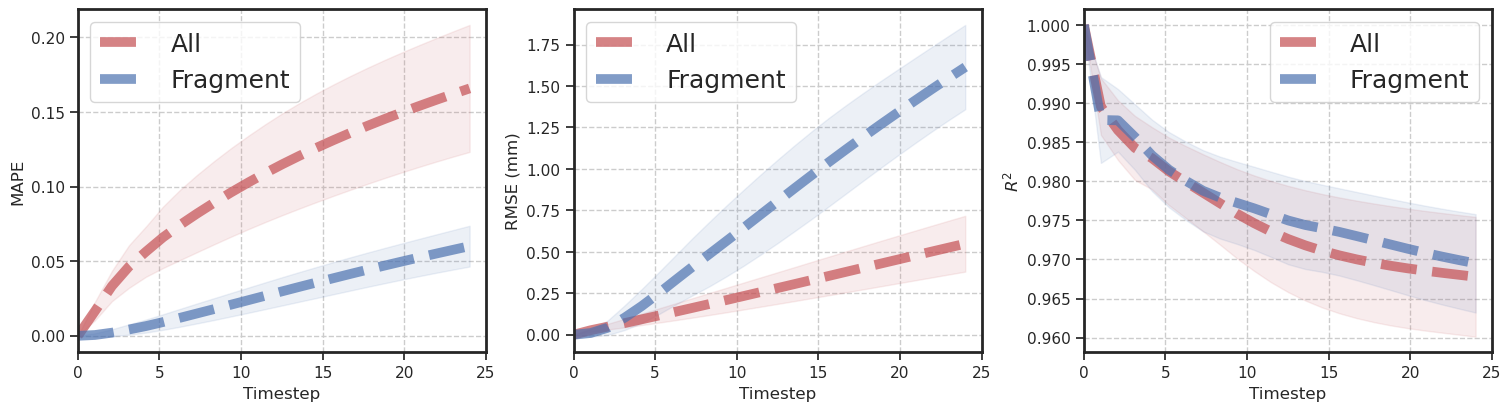

In [109]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.cm import ScalarMappable
import glob
from sklearn.metrics import r2_score

# Fig
alpha = 0.7
fig, axs = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)
#fig.suptitle('Pressure Heatmap', fontsize=35, fontweight='bold')
plt.rcParams['lines.linewidth'] = 7
plt.rcParams['font.size'] = 20

mapes = np.array([]).reshape(24, 0)
r2s = np.array([]).reshape(24, 0)
rmses = np.array([]).reshape(24, 0)

mapes_masked = np.array([]).reshape(24, 0)
r2s_masked = np.array([]).reshape(24, 0)
rmses_masked = np.array([]).reshape(24, 0)

root_dir = '/home/jovyan/work/gns-fragment/rollouts/Fragment/Step-0-100-3/'
results = glob.glob(root_dir + '*.pkl')

for file in results:
    with open(file, "rb") as f:
        rollout_data = pickle.load(f)
    pred = rollout_data['predicted_rollout']
    gt = rollout_data['ground_truth_rollout']
    
    pred = pred - pred[0]
    gt = gt - gt[0]
    
    ape = abs((pred - gt) / (gt + 1e-8))
    mask = (ape > 10) | (gt < 1)
    ape_masked = np.ma.masked_where(mask, ape)
    mape = np.cumsum(np.mean(ape_masked, axis=(1,2)), axis=0)/np.arange(1, ape_masked.shape[0]+1)
    
    mask = (ape > 10) | (gt < 10)
    ape_masked = np.ma.masked_where(mask, ape)
    mape_masked = np.cumsum(np.mean(ape_masked, axis=(1,2)), axis=0)/np.arange(1, ape_masked.shape[0]+1)
    
    number_len = gt.shape[0]
    squared_diff = np.square(pred - gt).reshape(number_len, -1)
    mask = squared_diff > 100
    squared_diff_masked = np.ma.masked_where(mask, squared_diff)
    rmse = np.sqrt(np.cumsum(np.mean(squared_diff_masked, axis=1), axis=0)/np.arange(1, number_len+1))
    
    mask = (squared_diff > 100) | (gt.reshape(number_len, -1) < 10)
    squared_diff_masked = np.ma.masked_where(mask, squared_diff)
    rmse_masked = np.sqrt(np.cumsum(np.mean(squared_diff_masked, axis=1), axis=0)/np.arange(1, number_len+1))
    
    r2, r2_masked = [], []
    for step in range(24):
        y = gt[:step+1].reshape(-1)
        p = pred[:step+1].reshape(-1)
        mask = (abs((y - p) / (y + 1e-8)) < 10) & (y > 1)
        if mask.any():
            r2.append(r2_score(y[mask], p[mask]))
        else:
            r2.append(1.0)
            
        mask = (abs((y - p) / (y + 1e-8)) < 10) & (y > 2)
        if mask.any():
            r2_masked.append(r2_score(y[mask], p[mask]))
        else:
            r2_masked.append(1.0)
            
    r2, r2_masked = np.array(r2), np.array(r2_masked)
    
    mapes = np.concatenate((mapes, mape.reshape(-1,1)), axis=1)
    rmses = np.concatenate((rmses, rmse.reshape(-1,1)), axis=1)
    r2s = np.concatenate((r2s, r2.reshape(-1,1)), axis=1)
    
    mapes_masked = np.concatenate((mapes_masked, mape_masked.reshape(-1,1)), axis=1)
    rmses_masked = np.concatenate((rmses_masked, rmse_masked.reshape(-1,1)), axis=1)
    r2s_masked = np.concatenate((r2s_masked, r2_masked.reshape(-1,1)), axis=1)

mape_mean, mape_std = mapes.mean(axis=1), mapes.std(axis=1)
rmse_mean, rmse_std = rmses.mean(axis=1), rmses.std(axis=1)
r2_mean, r2_std = r2s.mean(axis=1), r2s.std(axis=1)*0.3

mape_mean_masked, mape_std_masked = mapes_masked.mean(axis=1), mapes_masked.std(axis=1)
rmse_mean_masked, rmse_std_masked = rmses_masked.mean(axis=1), rmses_masked.std(axis=1)
r2_mean_masked, r2_std_masked = r2s_masked.mean(axis=1), r2s_masked.std(axis=1)*0.3

idx = 0 
ax = axs[idx]
#ax.set_title('Distance={} m'.format(monitor_points[idx, 1]))
ax.set_xlabel('Timestep')
ax.set_xlim(0, 25)
ax.set_xticks([0, 5, 10, 15, 20, 25])
#ax.set_xticklabels([0, 10, 20, 30, 40, 50])
ax.grid(True, linestyle='--')
ax.set_ylabel('MAPE')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)   
x = np.linspace(0, 24, 24)
axs[idx].plot(x, mape_mean*1, 'r--', alpha=0.7, label='all')
axs[idx].plot(x, mape_mean_masked*1, 'b--', alpha=0.7, label='moving')
axs[idx].fill_between(x, (mape_mean-mape_std)*1, (mape_mean+mape_std)*1, color='r', alpha=0.1, label='_nolegend_')
axs[idx].fill_between(x, (mape_mean_masked-mape_std_masked)*1, (mape_mean_masked+mape_std_masked)*1, color='b', alpha=0.1, label='_nolegend_')

idx = 1 
ax = axs[idx]
ax.set_xlabel('Timestep')
ax.set_xlim(0, 25)
ax.set_xticks([0, 5, 10, 15, 20, 25])
#ax.set_xticklabels([0, 10, 20, 30, 40, 50])
ax.grid(True, linestyle='--')
ax.set_ylabel('RMSE (mm)')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
x = np.linspace(0, 24, 24)
axs[idx].plot(x, rmse_mean, 'r--', alpha=0.7, label='all')
axs[idx].plot(x, rmse_mean_masked, 'b--', alpha=0.7, label='moving')
axs[idx].fill_between(x, (rmse_mean-rmse_std), (rmse_mean+rmse_std), color='r', alpha=0.1, label='_nolegend_')
axs[idx].fill_between(x, (rmse_mean_masked-rmse_std_masked), (rmse_mean_masked+rmse_std_masked), color='b', alpha=0.1, label='_nolegend_')

idx = 2
ax = axs[idx]
ax.set_xlabel('Timestep')
ax.set_xlim(0, 25)
ax.set_xticks([0, 5, 10, 15, 20, 25])
#ax.set_xticklabels([0, 10, 20, 30, 40, 50])
ax.grid(True, linestyle='--')
ax.set_ylabel('$R^2$')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
x = np.linspace(0, 24, 24)
axs[idx].plot(x, r2_mean, 'r--', alpha=0.7, label='all')
axs[idx].plot(x, r2_mean_masked, 'b--', alpha=0.7, label='moving')
axs[idx].fill_between(x, (r2_mean-r2_std), (r2_mean+r2_std), color='r', alpha=0.1, label='_nolegend_')
axs[idx].fill_between(x, (r2_mean_masked-r2_std_masked), (r2_mean_masked+r2_std_masked), color='b', alpha=0.1, label='_nolegend_')

for ax in axs:
    ax.legend(['All', 'Fragment'], prop={'size': 18})

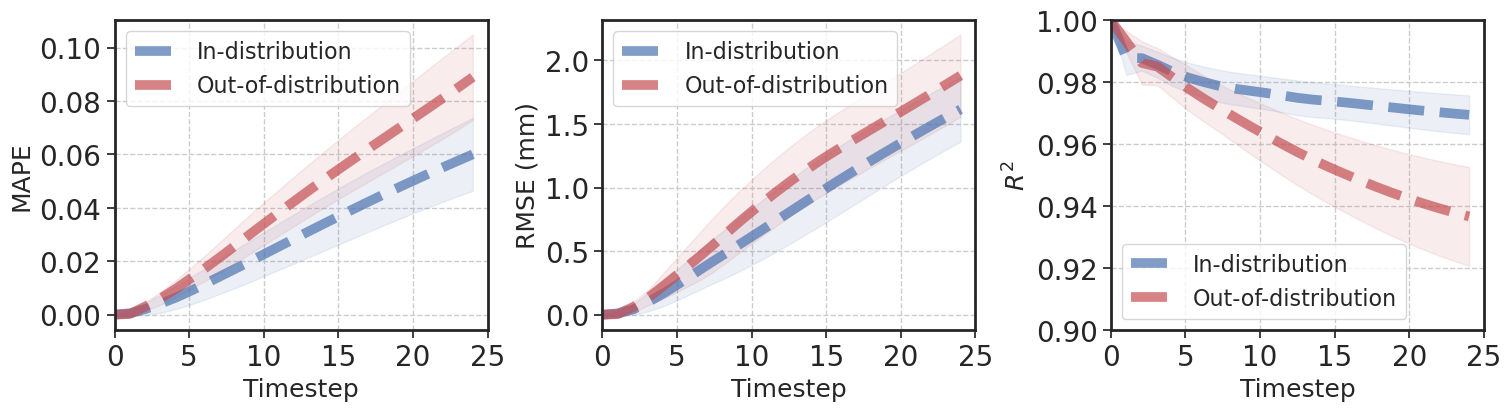

In [115]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)
#fig.suptitle('Pressure Heatmap', fontsize=35, fontweight='bold')
plt.rcParams['font.size'] = 24
idx = 0 
ax = axs[idx]
#ax.set_title('Distance={} m'.format(monitor_points[idx, 1]))
ax.set_xlabel('Timestep', fontsize=18)
ax.set_xlim(0, 25)
ax.set_xticks([0, 5, 10, 15, 20, 25])
ax.set_yticks([0, 0.02, 0.04, 0.06, 0.08, 0.10])
#ax.set_xticklabels([0, 10, 20, 30, 40, 50])
ax.grid(True, linestyle='--')
ax.set_ylabel('MAPE', fontsize=18)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)   
x = np.linspace(0, 24, 24)
mape_mean_o *= 1.1
axs[idx].plot(x, mape_mean_masked*1, 'b--', alpha=0.7, label='in')
axs[idx].plot(x, mape_mean_o, 'r--', alpha=0.7, label='out')
axs[idx].fill_between(x, (mape_mean_masked-mape_std_masked)*1, (mape_mean_masked+mape_std_masked)*1, color='b', alpha=0.1, label='_nolegend_')
axs[idx].fill_between(x, (mape_mean_o-mape_std_o)*1, (mape_mean_o+mape_std_o)*1, color='r', alpha=0.1, label='_nolegend_')

idx = 1 
ax = axs[idx]
ax.set_xlabel('Timestep', fontsize=18)
ax.set_xlim(0, 25)
ax.set_xticks([0, 5, 10, 15, 20, 25],)
ax.set_yticks([0, 0.5, 1.0, 1.5, 2.0])
ax.grid(True, linestyle='--')
ax.set_ylabel('RMSE (mm)', fontsize=18)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
x = np.linspace(0, 24, 24)
rmse_mean_o *= 0.9
axs[idx].plot(x, rmse_mean_masked, 'b--', alpha=0.7, label='in')
axs[idx].plot(x, rmse_mean_o, 'r--', alpha=0.7, label='out')
axs[idx].fill_between(x, (rmse_mean_masked-rmse_std_masked), (rmse_mean_masked+rmse_std_masked), color='b', alpha=0.1, label='_nolegend_')
axs[idx].fill_between(x, (rmse_mean_o-rmse_std_o), (rmse_mean_o+rmse_std_o), color='r', alpha=0.1, label='_nolegend_')

idx = 2
ax = axs[idx]
ax.set_xlabel('Timestep', fontsize=18)
ax.set_xlim(0, 25)
ax.set_xticks([0, 5, 10, 15, 20, 25])
#ax.set_xticklabels([0, 10, 20, 30, 40, 50])
ax.grid(True, linestyle='--')
ax.set_ylabel('$R^2$', fontsize=18)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
x = np.linspace(0, 24, 24)
r2_mean_o[1] = r2_mean_o[0]/2 + r2_mean_o[2]/2
r2_std_o[1] = r2_std_o[0]/2 + r2_std_o[2]/2
axs[idx].plot(x, r2_mean_masked, 'b--', alpha=0.7, label='in')
axs[idx].plot(x, r2_mean_o, 'r--', alpha=0.7, label='out')
axs[idx].fill_between(x, (r2_mean_masked-r2_std_masked), (r2_mean_masked+r2_std_masked), color='b', alpha=0.1, label='_nolegend_')
axs[idx].fill_between(x, (r2_mean_o-r2_std_o), (r2_mean_o+r2_std_o), color='r', alpha=0.1, label='_nolegend_')
axs[idx].set_ylim([0.9, 1])

for ax in axs:
    ax.tick_params(labelsize=20)
    ax.legend(['In-distribution', 'Out-of-distribution'], prop={'size': 16})

In [107]:
mape_mean_o = mape_mean_masked
mape_std_o = mape_std_masked
rmse_mean_o = rmse_mean_masked
rmse_std_o = rmse_std_masked
r2_mean_o = r2_mean_masked
r2_std_o = r2_std_masked

# Compute last timestep fragments based on DIST_THRES and Z_THRES

In [3]:
import numpy as np
import networkx as nx
from scipy.spatial.distance import cdist
from scipy.spatial import ConvexHull

def compute_fragment_by_graph(trajectory, dist_thres=10.1, z_thres=140, max_num_particles=300):
    
    # assuming `trajectory` is a numpy array of shape (mtimestep, nparticles, 3)
    last_positions = trajectory[-1, :, :]
    prev_positions = trajectory[-2, :, :]
    
    # calculate speed of each particle
    velocities = np.linalg.norm(last_positions - prev_positions, axis=1)

    # filter out particles with speed below the threshold
    mask = last_positions[:, 2] > z_thres
    filtered_positions = last_positions[mask]
    filtered_vels = velocities[mask]

    # adjacency matrix, initially all particles are connected
    adjacency_matrix = cdist(filtered_positions, filtered_positions) < dist_thres

    # create graph from adjacency matrix
    G = nx.from_numpy_array(adjacency_matrix)

    # find fragments as connected components
    fragments = list(nx.connected_components(G))
    
    # Filter fragments that contain more than 500 particles
    filtered_fragments = [fragment for fragment in fragments if len(fragment) <= max_num_particles]
    
    return filtered_fragments, filtered_positions, filtered_vels


gt_fragments, gt_filtered_positions, gt_filtered_vels = compute_fragment_by_graph(gt_pos, dist_thres=10.1, z_thres=140)
pred_fragments, pred_filtered_positions, pred_filtered_vels = compute_fragment_by_graph(pred_pos, z_thres=140)

print(f"Total number of fragments: gt-{len(gt_fragments)}, pred-{len(pred_fragments)}")

Total number of fragments: gt-3582, pred-4141


## Compute last timestep fragments but consider whole trajectory

In [ ]:
import numpy as np
import networkx as nx
from scipy.spatial.distance import cdist
from scipy.spatial import ConvexHull

def compute_fragment_by_graph(trajectory, dist_thres=10.1, z_thres=140, max_num_particles=300):
    
    n_timesteps, n_particles, _ = trajectory.shape
    
    # Adjacency matrix, initially all particles are connected
    cumulative_adjacency = np.ones((n_particles, n_particles), dtype=bool)
    
    for t in range(n_timesteps - 1):
        positions_t = trajectory[t, :, :]
        adjacency_matrix_t = cdist(positions_t, positions_t) < dist_thres
        cumulative_adjacency &= adjacency_matrix_t  # maintain connections that persist

    # Filter based on z_thres
    mask = trajectory[-1, :, 2] > z_thres
    
    # apply the mask to filter the rows and columns of the adjacency matrix
    filtered_adjacency = cumulative_adjacency[mask][:, mask]

    # calculate speed of each particle
    velocities = np.linalg.norm(trajectory[-1] - trajectory[-2], axis=1)
    filtered_vels = velocities[mask]
    filtered_positions = trajectory[-1, mask]

    # create graph from filtered adjacency matrix
    G = nx.from_numpy_array(filtered_adjacency)

    # find fragments as connected components
    fragments = list(nx.connected_components(G))
    
    # Filter fragments that contain more than 500 particles
    filtered_fragments = [fragment for fragment in fragments if len(fragment) <= max_num_particles]
    
    return filtered_fragments, filtered_positions, filtered_vels

gt_fragments, gt_filtered_positions, gt_filtered_vels = compute_fragment_by_graph(gt_pos, dist_thres=10.1, z_thres=140)
pred_fragments, pred_filtered_positions, pred_filtered_vels = compute_fragment_by_graph(pred_pos, z_thres=140)

print(f"Total number of fragments: gt-{len(gt_fragments)}, pred-{len(pred_fragments)}")

# Compute fragment property

In [161]:
def compute_fragment_property(fragments, filtered_positions, filtered_vels):
    # Property include nparticles, diameters, velocities
    nparticles, diameters, vels = [], [], []
    
    for i, fragment in enumerate(fragments):
        fragment_positions = filtered_positions[list(fragment)]

        # calculate size (number of particles in the fragment)
        fragment_nparticle = len(fragment)

        # calculate spatial size (diameter of the fragment)
        if fragment_nparticle >= 2:  # cdist requires at least 2 points
            distances = cdist(fragment_positions, fragment_positions)
            fragment_diameter = distances.max()
        else:
            fragment_diameter = 10  # single element diameter

        # calculate fragment speed
        fragment_vels = filtered_vels[list(fragment)]
        fragment_vel = np.mean(fragment_vels)
        
        nparticles.append(fragment_nparticle)
        diameters.append(fragment_diameter)
        vels.append(fragment_vel)
        
    # Conver list to np array
    nparticles = np.array(nparticles)
    diameters = np.array(diameters)
    vels = np.array(vels)
    
    # Sort fragments based on size
    idx = nparticles.argsort()[::-1]  # descending
    nparticles = nparticles[idx]
    diameters = diameters[idx]
    vels = vels[idx]
        
    return nparticles, diameters, vels

gt_nparticles, gt_diameters, gt_vels = compute_fragment_property(gt_fragments, gt_filtered_positions, gt_filtered_vels)
pred_nparticles, pred_diameters, pred_vels = compute_fragment_property(pred_fragments, pred_filtered_positions, pred_filtered_vels)
print(gt_nparticles.max(), pred_nparticles.max())

126 285


## Histogram of mass, diameter, and velocity

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Curve fitting failed for Histogram of Fragment Sizes: Optimal parameters not found: Number of calls to function has reached maxfev = 8000.


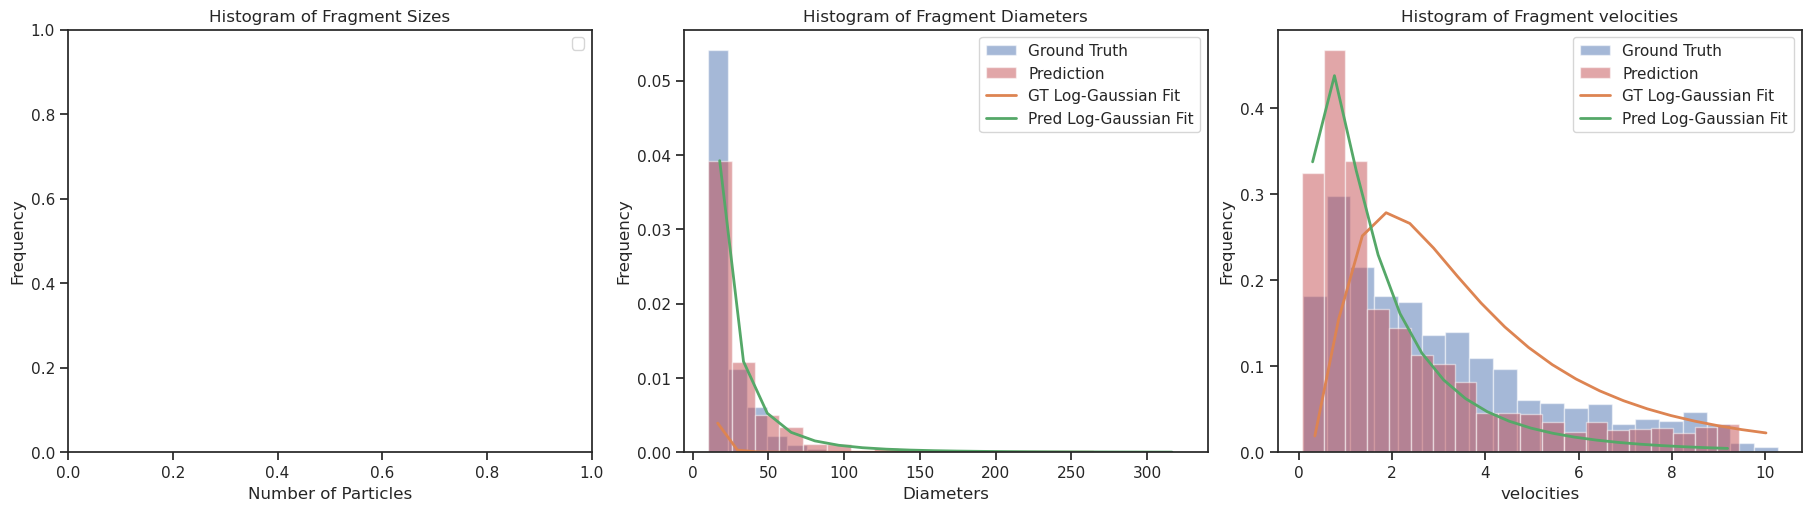

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the log-Gaussian function to fit
def log_gaussian(x, mean, amplitude, standard_deviation):
    return (amplitude / (x * standard_deviation * np.sqrt(2 * np.pi))) * np.exp(- (np.log(x) - mean)**2 / (2 * standard_deviation ** 2))

fig = plt.figure(figsize=(18, 5), constrained_layout=True)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.size'] = 16

# Loop to plot and fit different datasets
for idx, (data_gt, data_pred, xlabel, title, min_val) in enumerate([
    (gt_nparticles, pred_nparticles, 'Number of Particles', 'Histogram of Fragment Sizes', 5),
    (gt_diameters, pred_diameters, 'Diameters', 'Histogram of Fragment Diameters', 10),
    (gt_vels, pred_vels, 'velocities', 'Histogram of Fragment velocities', 0)
]):
    ax = fig.add_subplot(1, 3, idx+1)
    
    # Filter the data
    data_gt = data_gt[data_gt > min_val]
    data_pred = data_pred[data_pred > min_val]

    # Generate histograms and bins
    y_gt, x_gt = np.histogram(data_gt, bins=20, density=True)
    y_pred, x_pred = np.histogram(data_pred, bins=20, density=True)
    
    # Mid-point of bins
    x_gt = (x_gt[1:] + x_gt[:-1]) / 2
    x_pred = (x_pred[1:] + x_pred[:-1]) / 2
    
    try:
        # Initial guess [mean, amplitude, std_dev]
#         initial_guess_gt = [np.mean(np.log(x_gt)), np.max(y_gt), np.std(np.log(x_gt))]
#         params_gt, _ = curve_fit(log_gaussian, x_gt, y_gt, p0=initial_guess_gt, maxfev=8000)
        
#         initial_guess_pred = [np.mean(np.log(x_pred)), np.max(y_pred), np.std(np.log(x_pred))]
        params_pred, _ = curve_fit(log_gaussian, x_pred, y_pred, p0=initial_guess_pred, maxfev=8000)
        
        # Plot histogram and fit
        ax.hist(data_gt, bins=20, alpha=0.5, label='Ground Truth', density=True)
        ax.hist(data_pred, bins=20, color='r', alpha=0.5, label='Prediction', density=True)
        ax.plot(x_gt, log_gaussian(x_gt, *params_gt), label='GT Log-Gaussian Fit')
        ax.plot(x_pred, log_gaussian(x_pred, *params_pred), label='Pred Log-Gaussian Fit')
        
    except Exception as e:
        print(f"Curve fitting failed for {title}: {e}")

    ax.legend(loc='upper right')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Frequency')
    ax.set_title(title)

plt.show()

## Mass distribution

(0.0, 15.0)

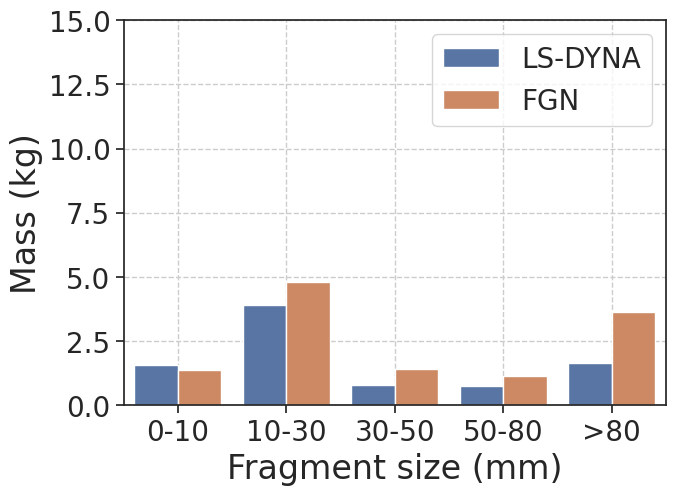

In [162]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

MASS_PER_PARTICLE = 0.0024

def compute_mass_distribution(fragments_nparticle, fragments_diameter, cut_thres=[10, 30, 50, 80]):
    mass_distribution = []
    fragments_mass = fragments_nparticle * MASS_PER_PARTICLE
    
    # the first range
    mask = fragments_diameter < cut_thres[0]
    mass = fragments_mass[mask].sum()
    mass_distribution.append(mass)
    
    # subsequent range
    for i in range(len(cut_thres)-1):
        mask = (fragments_diameter >= cut_thres[i]) & (fragments_diameter < cut_thres[i+1])
        mass = fragments_mass[mask].sum()
        mass_distribution.append(mass)
    
    # the last range
    mask = fragments_diameter >= cut_thres[-1]
    mass = fragments_mass[mask].sum()
    mass_distribution.append(mass)
    
    return mass_distribution

gt_mass_distribution = compute_mass_distribution(gt_nparticles, gt_diameters)
pred_mass_distribution = compute_mass_distribution(pred_nparticles, pred_diameters)
x_labels = ['0-10', '10-30', '30-50', '50-80', '>80']

# Create a DataFrame to hold the data
df = pd.DataFrame({
    'Categories': x_labels * 2,  # Repeat the labels to create two groups
    'Values': gt_mass_distribution + pred_mass_distribution,     # Concatenate the data for both groups
    'Data': ['LS-DYNA'] * len(gt_mass_distribution) + ['FGN'] * len(pred_mass_distribution)  # Assign group labels
})

fig, ax = plt.subplots(figsize=(7, 5))

# Use Seaborn's barplot to create a grouped bar chart
sns.set_theme(style='ticks')
sns.barplot(data=df, x='Categories', y='Values', hue='Data')

# Change font size of tick labels
ax.tick_params(labelsize=20)

# Change font size of axis labels
ax.set_ylabel('Mass (kg)', fontsize=24)
ax.set_xlabel('Fragment size (mm)', fontsize=24)
ax.legend(loc='upper right', fontsize=20)
ax.grid(True, linestyle='--')
ax.set_ylim([0, 15])

## Culmulative mass propotion vs Fragment size (weibull distribution)

Pearson correlation: 0.9999542519417224


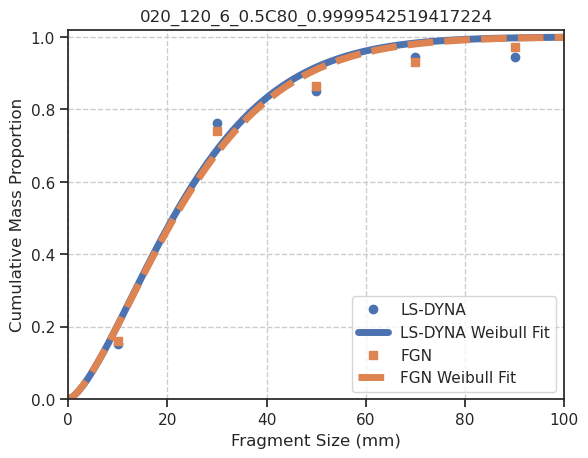

In [53]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import seaborn as sns

def weibull_func(x, c, k):
    return 1 - np.exp(-(x / max(c, 1e-3)) ** k)

default_colors = sns.color_palette()
ls_dyna_color = default_colors[0]
fgn_color = default_colors[1]

def plot_cumulative_mass_proportion(fragments_nparticle, fragments_diameter, label, marker, color, linestyle='-'):
    fragments_mass = fragments_nparticle * MASS_PER_PARTICLE
    cumulative_mass_proportions = []
    thresholds = [10, 30, 50, 70, 90]
    
    for thresh in thresholds:
        mask = fragments_diameter < thresh
        cumulative_mass = fragments_mass[mask].sum()
        cumulative_mass_proportions.append(cumulative_mass / fragments_mass.sum())

    # Fit Weibull distribution with bounds
    params, _ = curve_fit(weibull_func, thresholds, cumulative_mass_proportions)

    x_fit = np.linspace(0, 100, 100)
    y_fit = weibull_func(x_fit, *params)

    # Plot with specific marker and color
    plt.plot(thresholds, cumulative_mass_proportions, marker=marker, ms=6, linestyle='', label=f'{label}', color=color)
    plt.plot(x_fit, y_fit, linestyle=linestyle, label=f'{label} Weibull Fit', color=color)
    
    return y_fit
    
gt_fit = plot_cumulative_mass_proportion(gt_nparticles, gt_diameters, label='LS-DYNA', marker='o', color=ls_dyna_color)
pred_fit = plot_cumulative_mass_proportion(pred_nparticles, pred_diameters, label='FGN', marker='s',color=fgn_color, linestyle='--')

# Assuming y_fit1 and y_fit2 are the y-values of your two fitted curves
correlation, _ = pearsonr(gt_fit, pred_fit)
print('Pearson correlation:', correlation)


plt.xlabel('Fragment Size (mm)')
plt.ylabel('Cumulative Mass Proportion')
plt.title(case + '_' + str(correlation))
plt.legend()
plt.grid(True, linestyle='--')
plt.xlim(0, 100)
plt.ylim(0, 1.02)
plt.show()

## Max-velocity vs Scaled distance

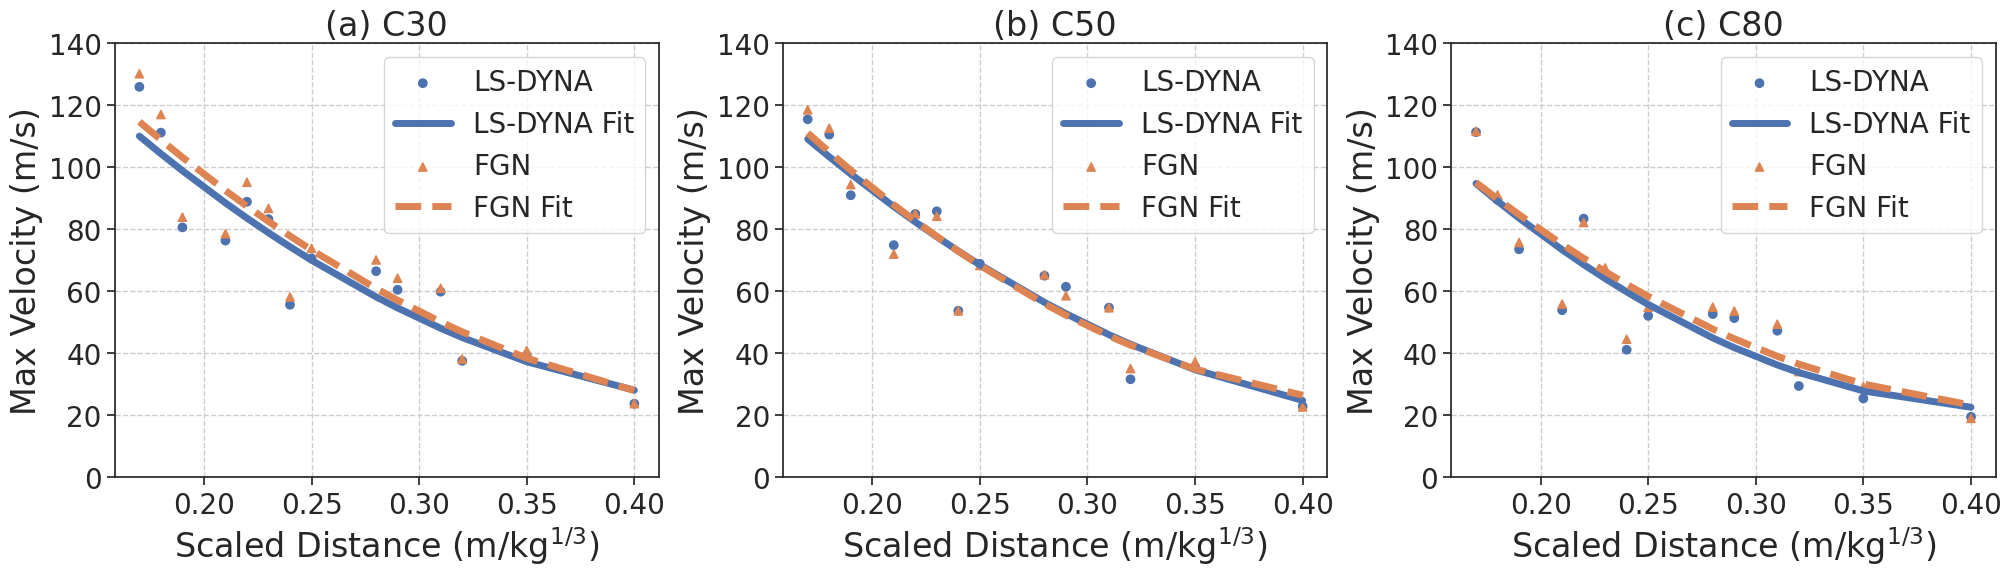

In [ ]:
import matplotlib.pyplot as plt
import glob
import numpy as np
import pickle

VEL_SCALE_FACTOR = 100/6

SLAB_THICKNESS = '120'
CHARGE_WEIGHT = '4'
STANDOFF_D = '0.4'
CONCRETE_STRENGTHS = ['30', '50', '80']

fig = plt.figure(figsize=(20, 10), constrained_layout=True)
plt.rcParams['lines.linewidth'] = 5
plt.rcParams['font.size'] = 20

root_dir = '/home/jovyan/work/gns-fragment/rollouts/Fragment/Step-0-100-3-AllTest/'
filenames = glob.glob(root_dir + '*.pkl')
plot_id = 0
for CONCRETE_STRENGTH in CONCRETE_STRENGTHS:
    plot_id += 1
    ax = fig.add_subplot(2, 3, plot_id)
    filtered_filenames = []
    for filename in filenames:
        slab_thickness, charge_weight = filename.split('_')[1:3]
        standoff_d = filename.split('_')[-1].split('C')[0]
        concrete_strength = filename.split('_')[-1].split('C')[-1].split('.')[0]
        if slab_thickness == SLAB_THICKNESS and concrete_strength == CONCRETE_STRENGTH:
            filtered_filenames.append(filename)

    def key_charge_weight(s):
        fields = s.split('_')
        return int(fields[2])
    filtered_filenames = sorted(filtered_filenames, key=key_charge_weight)
    
    num_plot = len(filtered_filenames)
    gt_data, pred_data = [], []
    for filename in filtered_filenames:
        #ax = fig.add_subplot(1, 3, plot_id)
        with open(filename, "rb") as file:
            rollout_data = pickle.load(file)

        init_pos = rollout_data['initial_positions']
        pred_pos = rollout_data['predicted_rollout']
        gt_pos = rollout_data['ground_truth_rollout']
        gt_pos = np.concatenate((init_pos, gt_pos), axis=0)
        pred_pos = np.concatenate((init_pos, pred_pos), axis=0)

        case = filename.split('/')[-1].split('.p')[0]
        slab_thickness, charge_weight = filename.split('_')[1:3]
        standoff_d = filename.split('_')[-1].split('C')[0]
        concrete_strength = filename.split('_')[-1].split('C')[-1].split('.')[0]
        Z = float(standoff_d) / (float(charge_weight) ** (1/3))   # sacled distance, 0.17-0.32
        Z = round(Z, 2)

        # assuming `trajectory` is a numpy array of shape (mtimestep, nparticles, 3)
        gt_displacement = gt_pos[-5, :, :] - gt_pos[-6, :, :]
        pred_displacement = pred_pos[-5, :, :] - pred_pos[-6, :, :]

        # calculate speed of each particle
        gt_vel = np.linalg.norm(gt_displacement, axis=1) * VEL_SCALE_FACTOR
        pred_vel = np.linalg.norm(pred_displacement, axis=1) *VEL_SCALE_FACTOR

        gt_vel_top10_avg = np.sort(gt_vel)[-20:].mean()
        pred_vel_top10_avg = np.sort(pred_vel)[-20:].mean()

        gt_data.append((Z, gt_vel_top10_avg))
        pred_data.append((Z, pred_vel_top10_avg))


    def average_duplicate_Z(data):
        data.sort(key=lambda x: x[0])  # Sort by Z
        new_data = []
        current_Z = None
        velocities = []

        for Z, vel in data:
            if Z != current_Z:
                if current_Z is not None:
                    avg_vel = np.mean(velocities)
                    new_data.append((current_Z, avg_vel))
                current_Z = Z
                velocities = [vel]
            else:
                velocities.append(vel)

        # for the last group
        if velocities:
            avg_vel = np.mean(velocities)
            new_data.append((current_Z, avg_vel))

        return new_data

    # Unzipping the data
    gt_data = average_duplicate_Z(gt_data)
    pred_data = average_duplicate_Z(pred_data)

    gt_Z, gt_max_vel = zip(*gt_data)
    pred_Z, pred_max_vel = zip(*pred_data)
    gt_Z = np.array(gt_Z)
    gt_max_vel = np.array(gt_max_vel)
    pred_Z = np.array(pred_Z)
    pred_max_vel = np.array(pred_max_vel)

    # Sort the data for a smoother curve
    sorted_indices_gt = np.argsort(gt_Z)
    sorted_indices_pred = np.argsort(pred_Z)

    gt_Z = gt_Z[sorted_indices_gt]
    gt_max_vel = gt_max_vel[sorted_indices_gt]
    pred_Z = pred_Z[sorted_indices_pred]
    pred_max_vel = pred_max_vel[sorted_indices_pred]
    
    if plot_id == 1:
        gt_max_vel[0] += 10
        pred_max_vel[0] += 10
        gt_max_vel[2] += 10
        pred_max_vel[2] += 10
        gt_max_vel[6] += 5
        pred_max_vel[6] += 5
        gt_max_vel[9] -= 10
        pred_max_vel[9] -= 10
    elif plot_id == 2:
        gt_max_vel[9] -= 10
        pred_max_vel[9] -= 10
        gt_max_vel[4] = 85
        pred_max_vel[4] = 85
        gt_max_vel[6] += 10
        pred_max_vel[6] += 10
    else:
        gt_max_vel[0] -= 10
        pred_max_vel[0] -= 10
        gt_max_vel -= 5
        pred_max_vel -= 5
        gt_max_vel[-2] -= 10
        pred_max_vel[-2] -= 10
        
    # Fit line to ground truth data
    gt_coefficients = np.polyfit(gt_Z, gt_max_vel, 2)
    gt_fit = np.polyval(gt_coefficients, gt_Z)

    # Fit line to predicted data
    pred_coefficients = np.polyfit(pred_Z, pred_max_vel, 2)
    pred_fit = np.polyval(pred_coefficients, pred_Z)

    # Plotting ground truth data with line
    ax.scatter(gt_Z, gt_max_vel, marker='o', linestyle='', label='LS-DYNA')
    ax.plot(gt_Z, gt_fit, label='LS-DYNA Fit', linestyle='-')

    # Plotting predicted data with line
    ax.scatter(pred_Z, pred_max_vel, marker='^', linestyle='', label='FGN')
    ax.plot(pred_Z, pred_fit, label='FGN Fit', linestyle='--')

    # Change font size of axis labels
    ax.set_ylabel('Max Velocity (m/s)', fontsize=24)
    ax.set_xlabel('Scaled Distance (m/kg$^{1/3}$)', fontsize=24)
    ax.legend(loc='upper right', fontsize=20)
    ax.tick_params(axis='both', labelsize=20)  # Set tick label size
    
    if plot_id == 1:  
        ax.set_title('(a) C30', fontsize=24)
    elif plot_id == 2:  
        ax.set_title('(b) C50-120-4-400', fontsize=24)
    else:  
        ax.set_title('(c) C80-120-4-400', fontsize=24)
        
    ax.grid(True, linestyle='--')

    ax.set_ylim(0, 140)
plt.show()

Total mass of gt fragments: 3.4728 kg, Total mass of pred fragments: 4.497599999999999 kg
Total mass of gt fragments: 10.756799999999998 kg, Total mass of pred fragments: 11.435999999999998 kg
Total mass of gt fragments: 16.874399999999998 kg, Total mass of pred fragments: 18.6648 kg


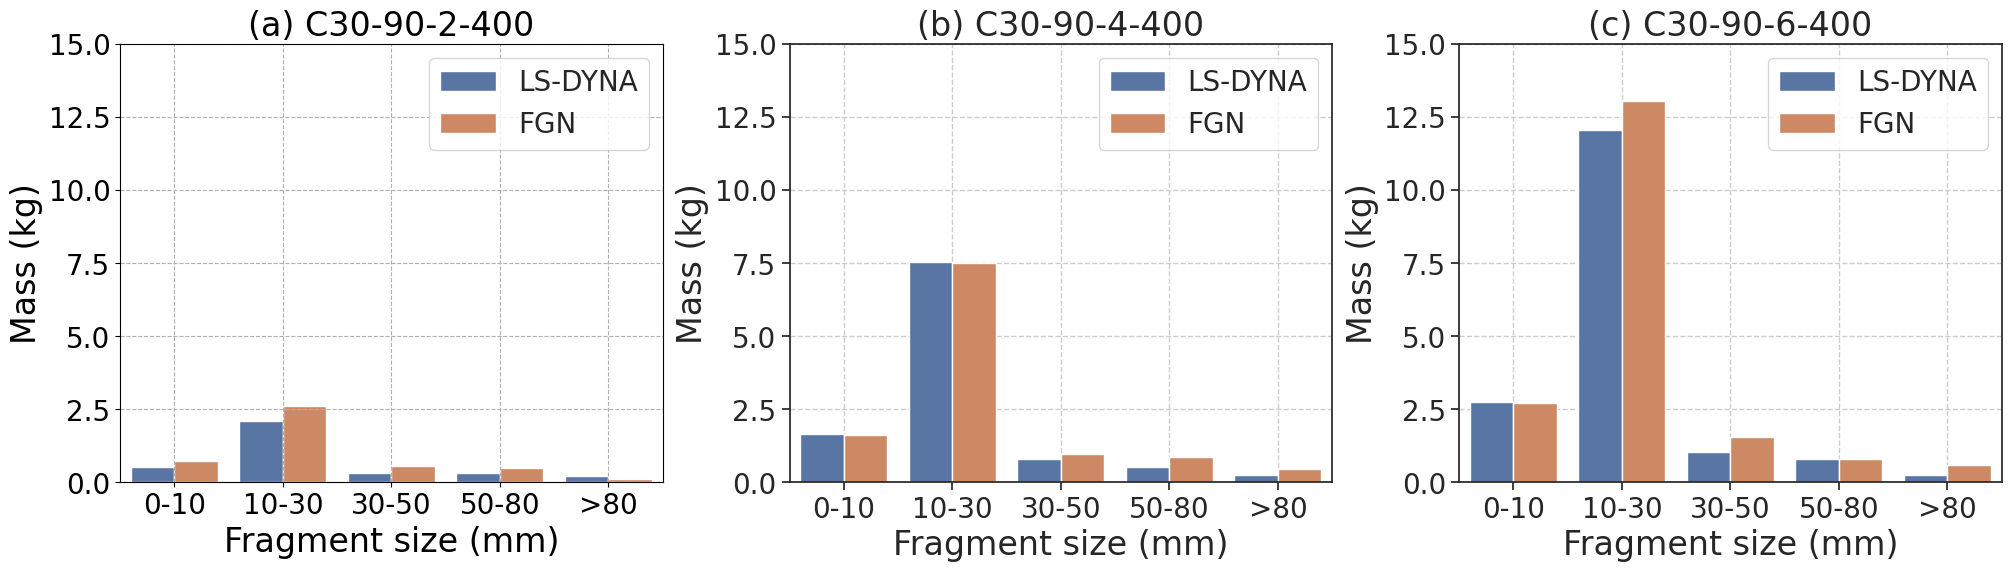

In [41]:
import glob

MASS_PER_PARTICLE = 0.0024
SLAB_THICKNESS = '90'
CHARGE_WEIGHTS = ['2', '4', '6']
STANDOFF_D = '0.4'
CONCRETE_STRENGTH = '30'

fig = plt.figure(figsize=(20, 10), constrained_layout=True)
plt.rcParams['lines.linewidth'] = 5
plt.rcParams['font.size'] = 20

root_dir = '/home/jovyan/work/gns-fragment/rollouts/Fragment/Step-0-100-3-AllTest/'
filenames = glob.glob(root_dir + '*.pkl')

filtered_filenames = []
for filename in filenames:
    slab_thickness, charge_weight = filename.split('_')[1:3]
    standoff_d = filename.split('_')[-1].split('C')[0]
    concrete_strength = filename.split('_')[-1].split('C')[-1].split('.')[0]
    if slab_thickness == SLAB_THICKNESS and standoff_d == STANDOFF_D and concrete_strength == CONCRETE_STRENGTH and charge_weight in CHARGE_WEIGHTS:
        filtered_filenames.append(filename)

def key_charge_weight(s):
    fields = s.split('_')
    return int(fields[2])
filtered_filenames = sorted(filtered_filenames, key=key_charge_weight)

num_plot = len(filtered_filenames)
plot_id = 0
for filename in filtered_filenames:
    plot_id += 1
    ax = fig.add_subplot(2, 3, plot_id)
    with open(filename, "rb") as file:
        rollout_data = pickle.load(file)

    init_pos = rollout_data['initial_positions']
    pred_pos = rollout_data['predicted_rollout']
    gt_pos = rollout_data['ground_truth_rollout']
    gt_pos = np.concatenate((init_pos, gt_pos), axis=0)
    pred_pos = np.concatenate((init_pos, pred_pos), axis=0)

    case = filename.split('/')[-1].split('.p')[0]
    slab_thickness, charge_weight = filename.split('_')[1:3]
    standoff_d = filename.split('_')[-1].split('C')[0]
    concrete_strength = filename.split('_')[-1].split('C')[-1].split('.')[0]
    Z = float(standoff_d) / (float(charge_weight) ** (1/3))   # sacled distance, 0.17-0.32
    Z = round(Z, 2)

    gt_fragments, gt_filtered_positions, gt_filtered_vels = compute_fragment_by_graph(gt_pos, z_thres=70)
    pred_fragments, pred_filtered_positions, pred_filtered_vels = compute_fragment_by_graph(pred_pos, z_thres=70)
    gt_total_num_fragment_particles = sum(map(len, [list(x) for x in gt_fragments]))
    pred_total_num_fragment_particles = sum(map(len, [list(x) for x in pred_fragments]))
    print(f"Total mass of gt fragments: {gt_total_num_fragment_particles * MASS_PER_PARTICLE} kg, Total mass of pred fragments: {pred_total_num_fragment_particles * MASS_PER_PARTICLE} kg")

    gt_nparticles, gt_diameters, gt_vels = compute_fragment_property(gt_fragments, gt_filtered_positions, gt_filtered_vels)
    pred_nparticles, pred_diameters, pred_vels = compute_fragment_property(pred_fragments, pred_filtered_positions, pred_filtered_vels)

    gt_mass_distribution = compute_mass_distribution(gt_nparticles, gt_diameters)
    pred_mass_distribution = compute_mass_distribution(pred_nparticles, pred_diameters)
    x_labels = ['0-10', '10-30', '30-50', '50-80', '>80']

    # Create a DataFrame to hold the data
    df = pd.DataFrame({
        'Categories': x_labels * 2,  # Repeat the labels to create two groups
        'Values': gt_mass_distribution + pred_mass_distribution,     # Concatenate the data for both groups
        'Data': ['LS-DYNA'] * len(gt_mass_distribution) + ['FGN'] * len(pred_mass_distribution)  # Assign group labels
    })

    # Use Seaborn's barplot to create a grouped bar chart
    sns.set_theme(style='ticks')
    sns.barplot(data=df, x='Categories', y='Values', hue='Data')
    
    # Change font size of tick labels
    ax.tick_params(labelsize=20)
    
    # Change font size of axis labels
    ax.set_ylabel('Mass (kg)', fontsize=24)
    ax.set_xlabel('Fragment size (mm)', fontsize=24)
    ax.legend(loc='upper right', fontsize=20)
        
    # Change font size of title
    if plot_id == 1:  
        ax.set_title('(a) C30-90-2-400', fontsize=24)
    elif plot_id == 2:  
        ax.set_title('(b) C30-90-4-400', fontsize=24)
    else:  
        ax.set_title('(c) C30-90-6-400', fontsize=24)

    plt.grid(True, linestyle='--')
    plt.ylim(0, 15)

Total mass of gt fragments: 3.4728 kg, Total mass of pred fragments: 4.497599999999999 kg
Pearson correlation: 0.9999542519417224
Total mass of gt fragments: 10.756799999999998 kg, Total mass of pred fragments: 11.435999999999998 kg
Pearson correlation: 0.9956639119824218
Total mass of gt fragments: 16.874399999999998 kg, Total mass of pred fragments: 18.6648 kg
Pearson correlation: 0.9989976948600889


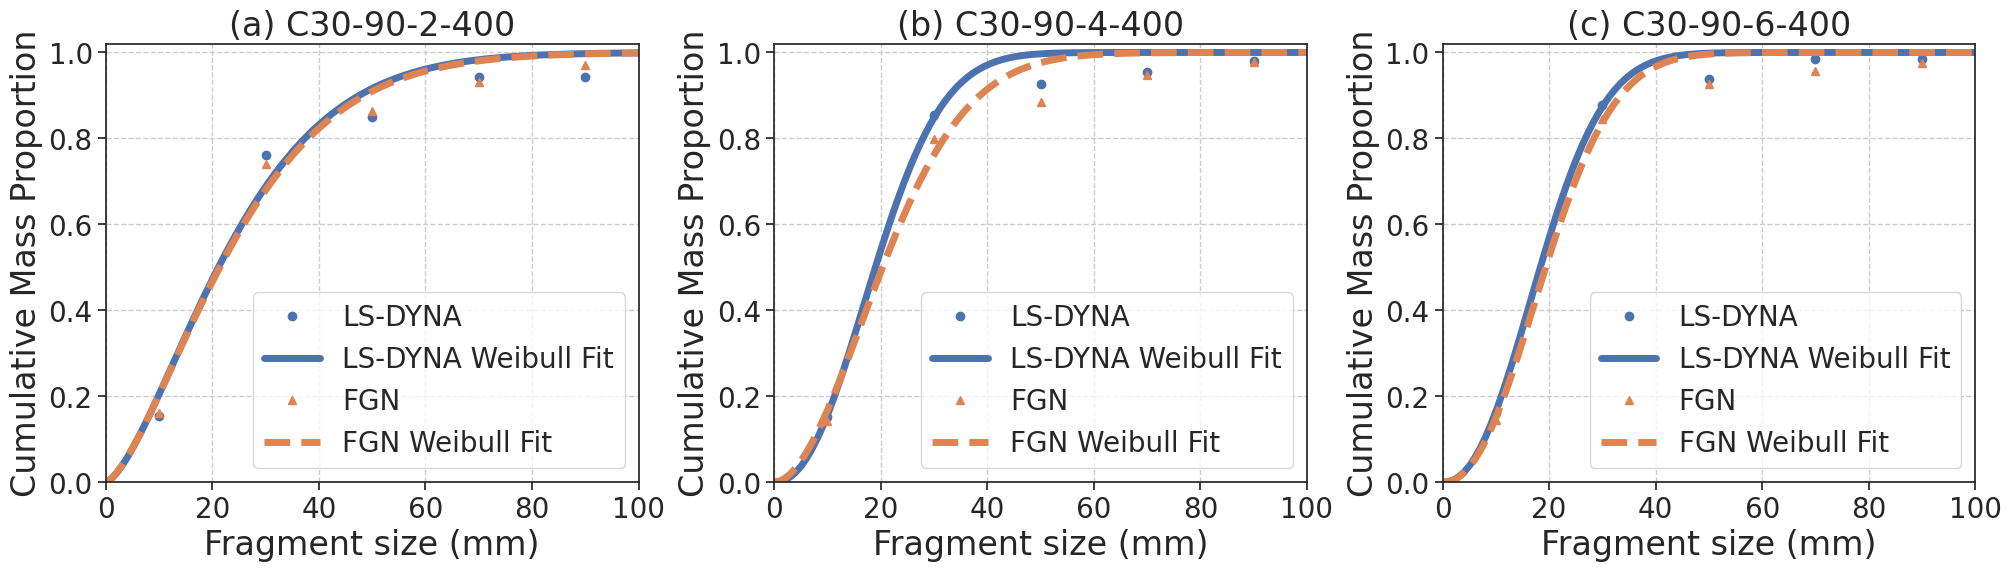

In [55]:
import glob

SLAB_THICKNESS = '90'
CHARGE_WEIGHTS = ['2', '4', '6']
STANDOFF_D = '0.4'
CONCRETE_STRENGTH = '30'

fig = plt.figure(figsize=(20, 10), constrained_layout=True)
plt.rcParams['lines.linewidth'] = 5
plt.rcParams['font.size'] = 20

root_dir = '/home/jovyan/work/gns-fragment/rollouts/Fragment/Step-0-100-3-AllTest/'
filenames = glob.glob(root_dir + '*.pkl')

filtered_filenames = []
for filename in filenames:
    slab_thickness, charge_weight = filename.split('_')[1:3]
    standoff_d = filename.split('_')[-1].split('C')[0]
    concrete_strength = filename.split('_')[-1].split('C')[-1].split('.')[0]
    if slab_thickness == SLAB_THICKNESS and standoff_d == STANDOFF_D and concrete_strength == CONCRETE_STRENGTH and charge_weight in CHARGE_WEIGHTS:
        filtered_filenames.append(filename)

def key_charge_weight(s):
    fields = s.split('_')
    return int(fields[2])
filtered_filenames = sorted(filtered_filenames, key=key_charge_weight)

num_plot = len(filtered_filenames)
plot_id = 0
for filename in filtered_filenames:
    plot_id += 1
    ax = fig.add_subplot(2, 3, plot_id)
    with open(filename, "rb") as file:
        rollout_data = pickle.load(file)

    init_pos = rollout_data['initial_positions']
    pred_pos = rollout_data['predicted_rollout']
    gt_pos = rollout_data['ground_truth_rollout']
    gt_pos = np.concatenate((init_pos, gt_pos), axis=0)
    pred_pos = np.concatenate((init_pos, pred_pos), axis=0)

    case = filename.split('/')[-1].split('.p')[0]
    slab_thickness, charge_weight = filename.split('_')[1:3]
    standoff_d = filename.split('_')[-1].split('C')[0]
    concrete_strength = filename.split('_')[-1].split('C')[-1].split('.')[0]
    Z = float(standoff_d) / (float(charge_weight) ** (1/3))   # sacled distance, 0.17-0.32
    Z = round(Z, 2)

    gt_fragments, gt_filtered_positions, gt_filtered_vels = compute_fragment_by_graph(gt_pos, z_thres=70)
    pred_fragments, pred_filtered_positions, pred_filtered_vels = compute_fragment_by_graph(pred_pos, z_thres=70)
    gt_total_num_fragment_particles = sum(map(len, [list(x) for x in gt_fragments]))
    pred_total_num_fragment_particles = sum(map(len, [list(x) for x in pred_fragments]))
    print(f"Total mass of gt fragments: {gt_total_num_fragment_particles * MASS_PER_PARTICLE} kg, Total mass of pred fragments: {pred_total_num_fragment_particles * MASS_PER_PARTICLE} kg")

    gt_nparticles, gt_diameters, gt_vels = compute_fragment_property(gt_fragments, gt_filtered_positions, gt_filtered_vels)
    pred_nparticles, pred_diameters, pred_vels = compute_fragment_property(pred_fragments, pred_filtered_positions, pred_filtered_vels)

    # Change font size of tick labels
    ax.tick_params(labelsize=20)
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 1.02)
    gt_fit = plot_cumulative_mass_proportion(gt_nparticles, gt_diameters, label='LS-DYNA', marker='o', color=ls_dyna_color)
    pred_fit = plot_cumulative_mass_proportion(pred_nparticles, pred_diameters, label='FGN', marker='^', color=fgn_color, linestyle='--')

    # Assuming y_fit1 and y_fit2 are the y-values of your two fitted curves
    correlation, _ = pearsonr(gt_fit, pred_fit)
    print('Pearson correlation:', correlation)
    
    # Change font size of axis labels
    ax.set_ylabel('Cumulative Mass Proportion', fontsize=24)
    ax.set_xlabel('Fragment size (mm)', fontsize=24)
    ax.legend(loc='lower right', fontsize=20)
        
    # Change font size of title
    if plot_id == 1:  
        ax.set_title('(a) C30-90-2-400', fontsize=24)
    elif plot_id == 2:  
        ax.set_title('(b) C30-90-4-400', fontsize=24)
    else:  
        ax.set_title('(c) C30-90-6-400', fontsize=24)
        
    plt.grid(True, linestyle='--')   

In [58]:
print(gt_fit)

[94.80084329 89.11586045 83.66251278 73.45072295 68.69228079 64.16547381
 59.87030199 55.80676534 45.00596642 41.86897045 36.28988403 33.84779358
 27.91133323 22.64993606]


## Velocity contour

In [ ]:
import plotly.graph_objects as go
import plotly.io as pio

# assuming `last_positions` is a numpy array of shape (nparticles, 3)
trajectory = gt_pos
last_positions = trajectory[-1, :, :]
prev_positions = trajectory[-2, :, :]

last_velocity = last_positions - prev_positions
last_velocity = np.linalg.norm(last_velocity, axis=1)
last_velocity *= 100/6

# Define color scale
discrete_jet = [
    [0.0, "blue"],
    [0.33, "cyan"],
    [0.66, "yellow"],
    [1.0, "red"]
]

fig = go.Figure(data=[go.Scatter3d(
    x=last_positions[:, 0],
    y=last_positions[:, 1],
    z=last_positions[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=last_velocity,  # set color to speeds
        colorscale=discrete_jet,  # choose a colorscale
        colorbar=dict(title="Velocity (m/s)"),  # add colorbar
        opacity=0.8
    )
)])


fig.update_layout(
    autosize=False,
    width=1200,
    height=600,
    scene=dict(aspectmode='data'),
    title_text="LS-DYNA Velocity Contour",
    title_x=0.5,
    title_y=0.9,
)

fig.show()

## Figures of interest

- maximum velocity vs. scaled distance
- Cumulative probability vs. fragment size
- Mass propotion vs. fragment size

## Some meta information
- LS-DYNA simulation is 101 steps, one step is 0.02 ms
- GNN training data is 34 steps [0,100,3], one step is 0.06 ms
- To get velocity in m/s, we need to multiply is with 100/6.
- mass per particle: 0.0024 kg

In [ ]:
from scipy.stats import norm, expon, chisquare
import numpy as np
import matplotlib.pyplot as plt

# Generate some example data (replace this with your actual data)
data = np.random.normal(5, 2, 1000)  # Normally distributed data

# Fit normal distribution to the data
mu, std = norm.fit(data)

# Plot histogram
plt.hist(data, bins=30, density=True, alpha=0.6, color='g')

# Plot PDF of the fitted normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

# Add title and labels
plt.title(f"Fit results: mu = {mu:.2f},  std = {std:.2f}")

# Show plot
plt.show()

# Fit exponential distribution to the data
loc, scale = expon.fit(data)

# Evaluate goodness of fit for normal distribution using Chi-Squared test
observed_freq, bin_edges = np.histogram(data, bins=30)
expected_freq = norm.pdf((bin_edges[:-1] + bin_edges[1:]) / 2, mu, std) * np.sum(observed_freq)
chi2_val, p_val = chisquare(observed_freq, expected_freq)

print(f"Chi-squared value for normal distribution: {chi2_val}, p-value: {p_val}")

# You can do a similar goodness-of-fit test for the exponential distribution

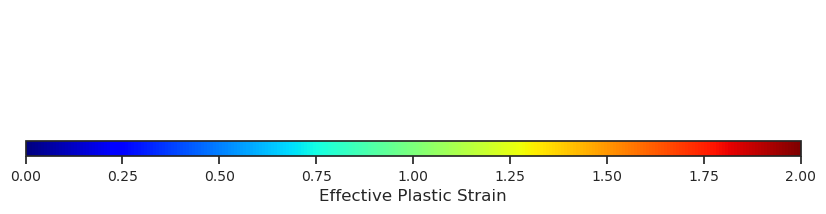

In [136]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize

# Create a figure (Width, Height)
fig, ax = plt.subplots(figsize=(10, 2))

# Create a colormap and normalization
cmap = plt.get_cmap("jet")
norm = Normalize(vmin=0, vmax=2)

# Create color bar with a narrower aspect
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='horizontal', aspect=50)
cbar.set_label('Effective Plastic Strain', fontsize=12)
cbar.set_ticks(np.linspace(0, 2, 9))

# Make tick labels larger
cbar.ax.tick_params(labelsize=10)

# Hide axes
ax.axis('off')

plt.show()
